# **Configuration**

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf


def configure_gpu(device_id: str = "0") -> None:
    """
    Configures the GPU for TensorFlow usage.

    Parameters:
    - device_id (str): The GPU device ID to use. Default is "0".

    Returns:
    - None: Prints TensorFlow version and GPU availability.
    """
    os.environ["CUDA_VISIBLE_DEVICES"] = device_id

    print(f'TensorFlow Version: {tf.__version__}')

    if tf.config.list_physical_devices('GPU'):
        print('GPU detected and configured!')
    else:
        print('No GPU found, using CPU.')


def set_random_seed(seed_value: int = 42) -> None:
    """
    Sets a fixed seed for random number generation to ensure reproducibility.

    Parameters:
    - seed_value (int): The seed value to set. Default is 42.

    Returns:
    - None: Prints confirmation of seed initialization.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

    print(f'Random seed initialized to {seed_value}.')


# Initialize seed and device configuration
set_random_seed()
configure_gpu()

# **Import**

In [1]:
import livelossplot
import pandas as pd
import seaborn as sns
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import load_model
from mne.time_frequency import psd_array_multitaper
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report

# **Data Preparation**

In [4]:
num_signals = 20000
signal_length = 3000
sampling_frequency = 100
bands = [(0.5, 4), (4, 8), (8, 12), (12, 30), (30, 50)]  # delta, theta, alpha, beta, gamma

In [5]:
def generate_synthetic_signal(length, sf, bands):
    t = np.arange(length) / sf
    signal = np.zeros(length)
    for low, high in bands:
        freq = np.random.uniform(low, high)
        amplitude = np.random.uniform(0.5, 1.5)
        signal += amplitude * np.sin(2 * np.pi * freq * t)
    signal += np.random.normal(0, 0.5, length)
    return signal


signals = []
for _ in range(num_signals):
    tmp = generate_synthetic_signal(signal_length, sampling_frequency, bands)
    #tmp_norm = (tmp - tmp.min())/(tmp.max() - tmp.min())
    signals.append(tmp)

signals = np.array(signals)

X_train, temp_signals = train_test_split(signals, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(temp_signals, test_size=0.5, random_state=42)

print("Train set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Train set: (16000, 3000)
Validation set: (2000, 3000)
Test set: (2000, 3000)


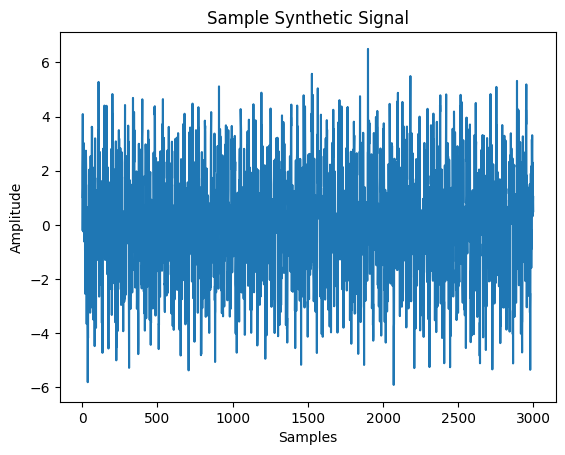

In [13]:
plt.plot(X_train[0])
plt.title("Sample Synthetic Signal")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

In [14]:
def calculate_bandpower(data, sf, bands):
    psd, freqs = psd_array_multitaper(data, sf, adaptive=True, normalization='full', verbose=0)
    total_power = np.trapz(psd, freqs)
    band_powers = []

    for band in bands:
        low, high = band
        idx_band = np.logical_and(freqs >= low, freqs <= high)
        band_power = np.trapz(psd[idx_band], freqs[idx_band])
        relative_power = band_power / total_power if total_power > 0 else 0
        band_powers.append(relative_power)

    return band_powers


def generate_labels(signals, sf, bands):
    labels = []
    all_band_powers = []

    for signal in signals:
        band_powers = calculate_bandpower(signal, sf, bands)
        all_band_powers.append(band_powers)

        band_powers_norm = (band_powers - np.min(band_powers)) / (np.max(band_powers) - np.min(band_powers))
        max_band = np.argmax(band_powers_norm)
        labels.append(max_band)

    return np.array(all_band_powers), np.array(labels)


train_band_powers, y_train = generate_labels(X_train, sampling_frequency, bands)
val_band_powers, y_val = generate_labels(X_val, sampling_frequency, bands)
test_band_powers, y_test = generate_labels(X_test, sampling_frequency, bands)

print("Band powers shape:", train_band_powers.shape)
print("Labels shape:", y_train.shape)

Band powers shape: (16000, 5)
Labels shape: (16000,)


# **Model**

In [86]:
def create_model():
    input_layer = keras.Input(shape=(signal_length, 1))

    # First Conv Layer
    x = layers.Conv1D(filters=32, kernel_size=3, strides=2, activation="relu", padding="same")(input_layer)
    x = layers.BatchNormalization()(x)

    # Second Conv Layer
    x = layers.Conv1D(filters=64, kernel_size=3, strides=2, activation="relu", padding="same")(x)

    # Third Conv Layer
    x = layers.Conv1D(filters=128, kernel_size=5, strides=2, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)

    # Fourth Conv Layer
    x = layers.Conv1D(filters=256, kernel_size=5, strides=2, activation="relu", padding="same")(x)

    # Replace Flatten with GlobalAveragePooling1D (Reduces output size and computation cost)
    x = layers.GlobalAveragePooling1D()(x)

    # Fully connected layers (Dense layers)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    output_layer = layers.Dense(5, activation="softmax")(x)

    return models.Model(inputs=input_layer, outputs=output_layer)


model = create_model()
model.compile(optimizer=Adam(learning_rate=5e-5),  #, weight_decay=1e-4 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 3000, 1)]         0         
                                                                 
 conv1d_60 (Conv1D)          (None, 1500, 32)          128       
                                                                 
 batch_normalization_30 (Bat  (None, 1500, 32)         128       
 chNormalization)                                                
                                                                 
 conv1d_61 (Conv1D)          (None, 750, 64)           6208      
                                                                 
 conv1d_62 (Conv1D)          (None, 375, 128)          41088     
                                                                 
 batch_normalization_31 (Bat  (None, 375, 128)         512       
 chNormalization)                                         

# **Train**

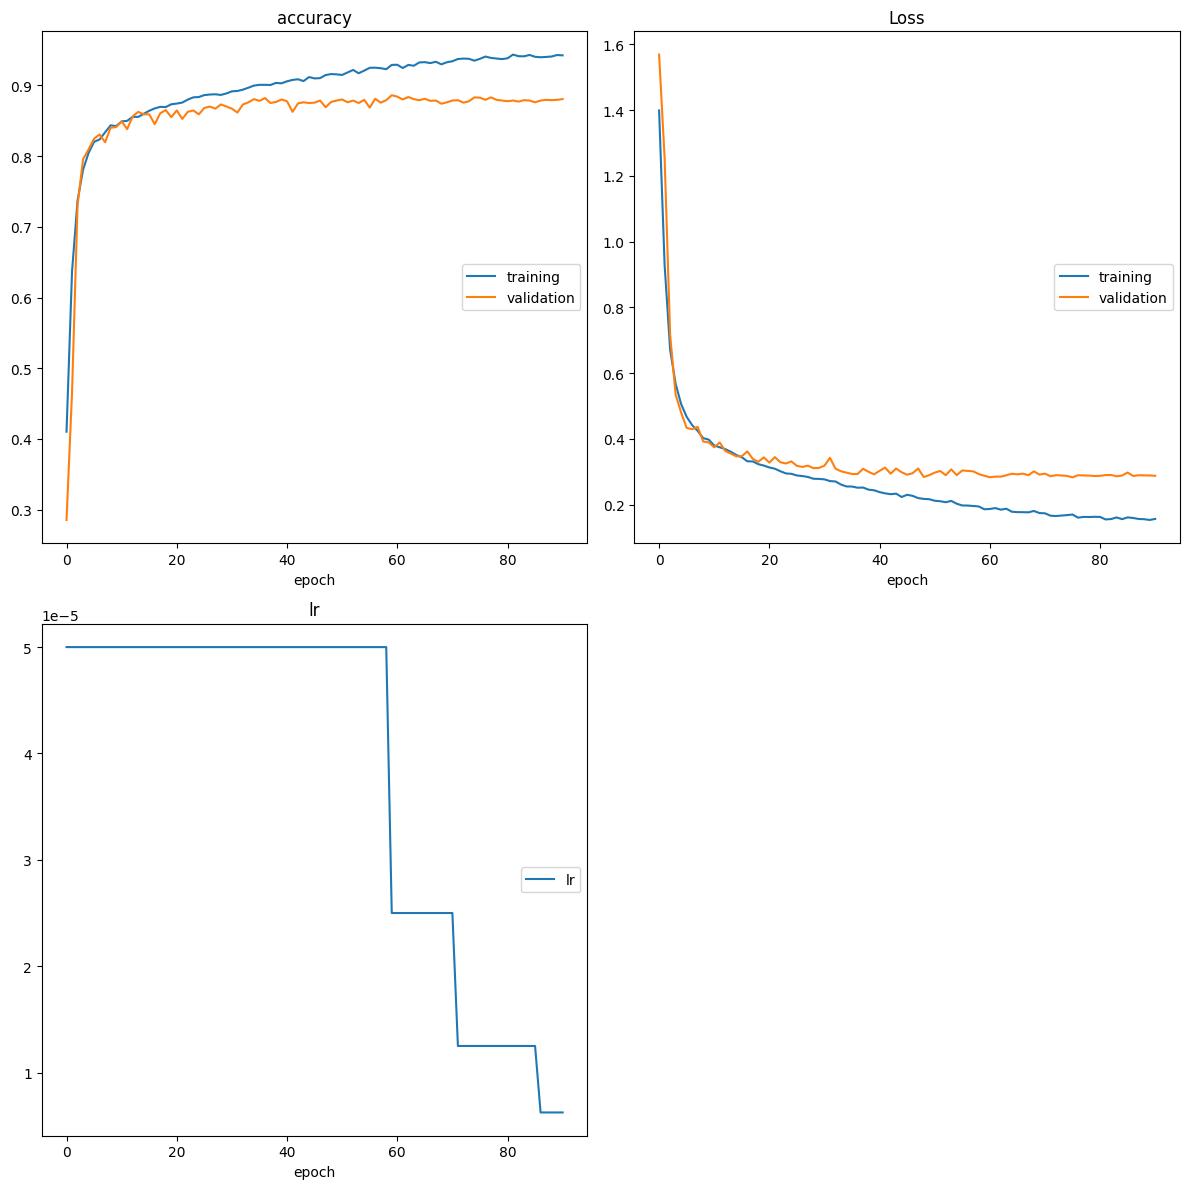

accuracy
	training         	 (min:    0.410, max:    0.943, cur:    0.942)
	validation       	 (min:    0.285, max:    0.886, cur:    0.881)
Loss
	training         	 (min:    0.153, max:    1.399, cur:    0.156)
	validation       	 (min:    0.283, max:    1.569, cur:    0.287)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
125/125 [==============================] - 1s 11ms/step - loss: 0.1562 - accuracy: 0.9424 - val_loss: 0.2875 - val_accuracy: 0.8805 - lr: 6.2500e-06


In [87]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.5,
                              patience=10,
                              min_lr=1e-6,
                              verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

model_chk = ModelCheckpoint('../models/band_power', monitor='val_loss', mode='min', save_best_only=True)

live_plot = livelossplot.PlotLossesKeras()

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=200,
                    batch_size=128,
                    callbacks=[reduce_lr, model_chk, early_stopping, live_plot])

# **Evaluation**

In [16]:
model = load_model('../models/band_power')
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

63/63 [==============================] - 0s 2ms/step - loss: 0.2630 - accuracy: 0.8885
Test Loss: 0.2630
Test Accuracy: 0.8885


In [ ]:
test_signals = X_test.reshape(-1, signal_length, 1)
y_pred = model.predict(test_signals)
y_pred_classes = np.argmax(y_pred, axis=1)
if len(y_test.shape) > 1:
    y_true_classes = np.argmax(y_test, axis=1)
else:
    y_true_classes = y_test

cm = confusion_matrix(y_test, y_pred_classes)
report = classification_report(y_test, y_pred_classes, output_dict=True)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

report = pd.DataFrame(report).transpose()
print("Classification Report:\n", report)